# Obfuscated Text Classification
### Mohammad Mahdavi,  1 October 2020

In [10]:
# Loading the necessary modules
import numpy
import pandas
import matplotlib
import IPython.display

import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.neural_network
import sklearn.model_selection
import sklearn.feature_extraction

import keras.utils
import keras.models
import keras.layers
import keras.optimizers
import keras.preprocessing
import keras.preprocessing.text

## 1. Introduction

### Problem and Challenges
We have a multiclass text classification task. However, there is a big challenge here: The input text is obfuscated. In fact, our input text is binary, just like image data. That is why we cannot leverage typical feature extraction approaches to represent the input text. In particular, we cannot tokenize, stem, normalize, etc. the input text.


### Approach Overview
Intuitively, we should design deep neural networks, such as CNN and LSTM, that can effectively and efficently featurize and classify these kinds of obfuscated input data. 

To principally address this problem, we conduct the following steps:
1. **Data exploration.** We first explore the data to understand the characteristics of our dataset.
2. **Traditional text classification.** We then build a traditional text classification pipeline to see what we can achieve without applying any complex deep learning models. 
3. **Deep learning-based text classification**. Based on the gained insigts from the first two steps, we next train a deep neural network to classify the obfuscated texts effectively and efficiently.
4. **Evaluating the trained model.** We then evaluate the trained model on an unseen validation set, splitted from the labeled training data.
5. **Conclusion.** We finally conclude our task with summarizing the insights and listing the limitations and the future work.

## 2. Data Exploration
Let us first load and explore the data.

,Data,Rows,Min Length,Max Length,Unique Characters
0,Train,32513,168,452,26
1,Test,3000,72,448,26


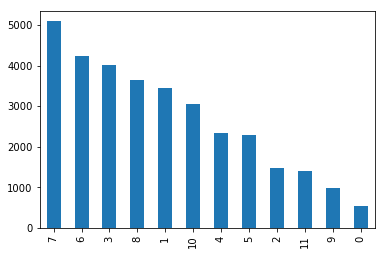

In [11]:
text_train = open("xtrain_obfuscated.txt", "r").read().splitlines()
text_test = open("xtest_obfuscated.txt", "r").read().splitlines()
labels_train = open("ytrain.txt", "r").read().splitlines()

metadata = pandas.DataFrame(columns=["Data", "Rows", "Min Length", "Max Length", "Unique Characters"])
metadata = metadata.append({"Data": "Train", "Rows": len(text_train), 
                            "Min Length": len(min(text_train, key=len)), 
                            "Max Length": len(max(text_train, key=len)), 
                            "Unique Characters": len(list(set("".join(text_train))))}, ignore_index=True)
metadata = metadata.append({"Data": "Test", "Rows": len(text_test), 
                            "Min Length": len(min(text_test, key=len)), 
                            "Max Length": len(max(text_test, key=len)), 
                            "Unique Characters": len(list(set("".join(text_test))))}, ignore_index=True)
IPython.display.display(metadata)
pandas.DataFrame({"Labels": labels_train})["Labels"].value_counts().plot(kind="bar")

### Insights
1. The obfuscated texts consist of 26 English characters. There is no spaces or other delimiters to tokenize the texts. Therefore, we cannot use any word-level representation and we must go for **character-level text representations**.
2. The classes are not significantly imblanced, which shows we can use **accuracy** as the evaluation measure.

## 3. Traditional Text Classification
As mentioned, intuitively, it makes more sense to train deep neural networks for this obfuscated text classification task. However, it is always nice to start with simpler approaches to gain some insights about their performances.
Here, we first design a simple text classification pipleline with typical character-level TF-IDF representaion and traditional classifiers. We then experiment the effect of the most important design decisions on the cross-validated performance. Based on the achieved insights, we will design a deep learning-based approach in the next section.

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def traditional_text_classification(model="DTC", n_gram=1):
    """
    This function builds a simple text classification pipeline based on the input parameters.
    """
    # Featurizing the data with charater-level TF-IDF representation
    tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(ngram_range=(1, n_gram), analyzer="char")
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(text_train)
    x_train = tfidf_vectorizer_vectors
    y_train = labels_train

    # Training and testing a classifier
    if model == "DTC":
        parameters_grid = {"criterion": ["gini", "entropy"]}
        clf = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeClassifier(), 
                                                   parameters_grid, scoring="accuracy", cv=5, n_jobs=-1)
    elif model == "MLP":
        parameters_grid = {"hidden_layer_sizes": [50, 100, 200], "max_iter": [300]}
        clf = sklearn.model_selection.GridSearchCV(sklearn.neural_network.MLPClassifier(), 
                                                   parameters_grid, scoring="accuracy", cv=5, n_jobs=-1)
    elif model == "GBC":
        parameters_grid = {"n_estimators": [50, 100, 200]}
        clf = sklearn.model_selection.GridSearchCV(sklearn.ensemble.GradientBoostingClassifier(), 
                                                   parameters_grid, scoring="accuracy", cv=5, n_jobs=-1)
    clf.fit(x_train, y_train)  
    return {"Model": model, "N-Gram": n_gram, "Accuracy": max(clf.cv_results_["mean_test_score"])}


results = pandas.DataFrame(columns=["Model", "N-Gram", "Accuracy"])

for model in ["DTC", "MLP", "GBC"]:
    print("Model =", model)
    result = traditional_text_classification(model=model)
    results = results.append(result, ignore_index=True)
    
for n_gram in [2, 3, 4]:
    print("N-Gram =", n_gram)
    result = traditional_text_classification(n_gram=n_gram)
    results = results.append(result, ignore_index=True)
    
results.head()

Model = DTC
Model = MLP
Model = GBC
N-Gram = 2
N-Gram = 3
N-Gram = 4


,Model,N-Gram,Accuracy
0,DTC,1,0.214653
1,MLP,1,0.401778
2,GBC,1,0.375481
3,DTC,2,0.377172
4,DTC,3,0.479777


### Insights
1. As expected, the **traditional feature representations** and classifiers **cannot achieve high accuracy** due to the nature of obfuscated input text data. We need to use deep learning-based approaches to achieve higher accuracy. 
2. Among different traditional classifiers that we tried, MLP achieves the highest accuracy. This observation also suggests to go for **deep neural networks** as the neural network-based models seem to be more suitable for this task rather than tree-based or ensemble-based models, such as decision tree and gradient boosting. 
3. Increasing N in the n-gram character-level representation clearly improves the accuracy. This observation shows that **recurrent deep neural networks**, such as LSTM, that are designed to **learn language modeling** could be promising for this task. That is why we will train an LSTM-based model in the next section. 

## 4. Deep Learning-Based Text Classification 
We can now train a deep neural network based on the insights we have gained so far. Therefore, we train a deep neural network including LSTM and CNN layers to learn the language modele of characters. We also split the data into train and validation sets to evaluate our model at the end on an unseen validation set. Note that there are a lot of hyperparameters in our designed network that can affect the performance of our model. We set them by try and error.

In [6]:
# Defining Constants
UNIQUE_CHARACTERS_COUNT = 26
MAX_STRING_LENGTH = 452

# Preparing the data
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(text_train)
character_sequences = tokenizer.texts_to_sequences(text_train)
sequence_matrix = keras.preprocessing.sequence.pad_sequences(character_sequences)
categorical_labels = keras.utils.to_categorical(labels_train)

# Splitting the data for having an unseen validation set for the final validation
x_train, x_validation, y_train, y_validation = sklearn.model_selection.train_test_split(
    sequence_matrix, categorical_labels, test_size=0.20)

def deep_learning_based_text_classification(embedding_size=50, dropout_1=0.20, filters=64, kernel_size=5,
                                            activation_1 = "relu", pool_size=4, lstm_size=50,
                                            dense_size_1=200, dense_size_2=12, activation_2 = "sigmoid",
                                            loss="binary_crossentropy", optimizer="adam",
                                            batch_size=250, epochs=100):
    """
    This function builds an deep learning-based text classification pipeline based on the input parameters.
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(UNIQUE_CHARACTERS_COUNT+1, embedding_size, input_length=MAX_STRING_LENGTH))    
    model.add(keras.layers.Dropout(dropout_1))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv1D(filters, kernel_size, activation=activation_1))
    model.add(keras.layers.MaxPooling1D(pool_size))
    model.add(keras.layers.LSTM(lstm_size))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(dense_size_1))
    model.add(keras.layers.BatchNormalization())   
    model.add(keras.layers.Dense(dense_size_2))
    model.add(keras.layers.Activation(activation_2))   
    model.summary()
    model.compile(loss=loss,optimizer=optimizer,metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    model.save("lstm_cnn.model")


deep_learning_based_text_classification()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 452, 50)           1350      
_________________________________________________________________
dropout_2 (Dropout)          (None, 452, 50)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 452, 50)           200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 448, 64)           16064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 112, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                23000     
_________________________________________________________________
batch_normalization_7 (Batch (None, 50)               

84/84 [==============================] - 22s 259ms/step - loss: 0.0804 - accuracy: 0.8107 - val_loss: 0.1165 - val_accuracy: 0.7324
Epoch 46/500
84/84 [==============================] - 22s 257ms/step - loss: 0.0808 - accuracy: 0.8131 - val_loss: 0.1147 - val_accuracy: 0.7445
Epoch 47/500
84/84 [==============================] - 21s 256ms/step - loss: 0.0782 - accuracy: 0.8209 - val_loss: 0.1439 - val_accuracy: 0.6805
Epoch 48/500
84/84 [==============================] - 22s 259ms/step - loss: 0.0797 - accuracy: 0.8144 - val_loss: 0.1184 - val_accuracy: 0.7495
Epoch 49/500
84/84 [==============================] - 22s 258ms/step - loss: 0.0792 - accuracy: 0.8179 - val_loss: 0.1308 - val_accuracy: 0.7092
Epoch 50/500
84/84 [==============================] - 22s 257ms/step - loss: 0.0779 - accuracy: 0.8195 - val_loss: 0.0999 - val_accuracy: 0.7714
Epoch 51/500
84/84 [==============================] - 22s 260ms/step - loss: 0.0774 - accuracy: 0.8218 - val_loss: 0.1190 - val_accuracy: 0.741

84/84 [==============================] - 22s 262ms/step - loss: 0.0517 - accuracy: 0.8877 - val_loss: 0.1280 - val_accuracy: 0.7661
Epoch 158/500
84/84 [==============================] - 22s 260ms/step - loss: 0.0488 - accuracy: 0.8929 - val_loss: 0.1152 - val_accuracy: 0.7710
Epoch 159/500
84/84 [==============================] - 22s 259ms/step - loss: 0.0490 - accuracy: 0.8928 - val_loss: 0.1182 - val_accuracy: 0.7705
Epoch 160/500
84/84 [==============================] - 22s 261ms/step - loss: 0.0486 - accuracy: 0.8925 - val_loss: 0.1321 - val_accuracy: 0.7651
Epoch 161/500
84/84 [==============================] - 22s 259ms/step - loss: 0.0496 - accuracy: 0.8936 - val_loss: 0.1141 - val_accuracy: 0.7722
Epoch 162/500
84/84 [==============================] - 22s 259ms/step - loss: 0.0488 - accuracy: 0.8957 - val_loss: 0.1231 - val_accuracy: 0.7601
Epoch 163/500
84/84 [==============================] - 22s 261ms/step - loss: 0.0492 - accuracy: 0.8915 - val_loss: 0.1170 - val_accuracy:

84/84 [==============================] - 22s 261ms/step - loss: 0.0395 - accuracy: 0.9192 - val_loss: 0.1337 - val_accuracy: 0.7518
Epoch 270/500
84/84 [==============================] - 22s 262ms/step - loss: 0.0403 - accuracy: 0.9144 - val_loss: 0.1236 - val_accuracy: 0.7762
Epoch 271/500
84/84 [==============================] - 22s 262ms/step - loss: 0.0391 - accuracy: 0.9189 - val_loss: 0.1249 - val_accuracy: 0.7764
Epoch 272/500
84/84 [==============================] - 22s 260ms/step - loss: 0.0386 - accuracy: 0.9209 - val_loss: 0.1285 - val_accuracy: 0.7730
Epoch 273/500
84/84 [==============================] - 22s 259ms/step - loss: 0.0387 - accuracy: 0.9209 - val_loss: 0.1270 - val_accuracy: 0.7643
Epoch 274/500
84/84 [==============================] - 22s 261ms/step - loss: 0.0386 - accuracy: 0.9203 - val_loss: 0.1283 - val_accuracy: 0.7695
Epoch 275/500
84/84 [==============================] - 22s 262ms/step - loss: 0.0378 - accuracy: 0.9220 - val_loss: 0.1286 - val_accuracy:

84/84 [==============================] - 22s 258ms/step - loss: 0.0333 - accuracy: 0.9334 - val_loss: 0.1559 - val_accuracy: 0.7572
Epoch 382/500
84/84 [==============================] - 22s 263ms/step - loss: 0.0346 - accuracy: 0.9304 - val_loss: 0.1337 - val_accuracy: 0.7732
Epoch 383/500
84/84 [==============================] - 22s 260ms/step - loss: 0.0323 - accuracy: 0.9364 - val_loss: 0.1363 - val_accuracy: 0.7661
Epoch 384/500
84/84 [==============================] - 22s 258ms/step - loss: 0.0328 - accuracy: 0.9364 - val_loss: 0.1493 - val_accuracy: 0.7537
Epoch 385/500
84/84 [==============================] - 22s 258ms/step - loss: 0.0334 - accuracy: 0.9333 - val_loss: 0.1452 - val_accuracy: 0.7620
Epoch 386/500
84/84 [==============================] - 22s 262ms/step - loss: 0.0324 - accuracy: 0.9348 - val_loss: 0.1459 - val_accuracy: 0.7618
Epoch 387/500
84/84 [==============================] - 22s 258ms/step - loss: 0.0326 - accuracy: 0.9360 - val_loss: 0.1361 - val_accuracy:

84/84 [==============================] - 22s 258ms/step - loss: 0.0289 - accuracy: 0.9455 - val_loss: 0.1568 - val_accuracy: 0.7599
Epoch 494/500
84/84 [==============================] - 22s 262ms/step - loss: 0.0282 - accuracy: 0.9465 - val_loss: 0.1496 - val_accuracy: 0.7691
Epoch 495/500
84/84 [==============================] - 22s 258ms/step - loss: 0.0289 - accuracy: 0.9432 - val_loss: 0.1542 - val_accuracy: 0.7612
Epoch 496/500
84/84 [==============================] - 22s 263ms/step - loss: 0.0285 - accuracy: 0.9475 - val_loss: 0.1484 - val_accuracy: 0.7718
Epoch 497/500
84/84 [==============================] - 22s 259ms/step - loss: 0.0279 - accuracy: 0.9476 - val_loss: 0.1476 - val_accuracy: 0.7712
Epoch 498/500
84/84 [==============================] - 22s 263ms/step - loss: 0.0287 - accuracy: 0.9449 - val_loss: 0.1480 - val_accuracy: 0.7730
Epoch 499/500
84/84 [==============================] - 22s 260ms/step - loss: 0.0284 - accuracy: 0.9457 - val_loss: 0.1479 - val_accuracy:

## 5. Final Evaluation and Prediction
Finally, it is time to evaluate our trained model on the validation set that we splitted from the training set. Next, we predict and store the labels of the given unlabeled test dataset.

In [15]:
# Validating the trained model on the unseen data
model = keras.models.load_model("lstm_cnn.model")
loss, accuracy = model.evaluate(x_validation, y_validation)
print("Validation Results:\nLoss = {:0.2f}\nAccuracy = {:0.2f}".format(loss, accuracy))

# Predicting labels of the given test set
character_sequences = tokenizer.texts_to_sequences(text_test)
sequence_matrix = keras.preprocessing.sequence.pad_sequences(character_sequences, maxlen=MAX_STRING_LENGTH)
prediction = model.predict(sequence_matrix)
f = open("ytest.txt", "w")
for i in range(len(text_test)):
    f.write(str(numpy.argmax(prediction[i])) + "\n")
f.close()
print("Predicted labels stored.")

204/204 [==============================] - 5s 23ms/step - loss: 0.1439 - accuracy: 0.7626
Validation Results:
Loss = 0.14
Accuracy = 0.76
Predicted labels stored.


## 6. Conclusion
We have addressed the obfuscated text classification task. Below, we first summarize the learned lessons and then list the limiatations and the future work.

### Summary of Insights
- We could not use typical feature extraction approaches, such as tokenization and TF-IDF representation, as our input textual data is obfuscated.
- We had to apply a character-level feature representation for the given textual dataset as the text values are continious letters, without any delimiters and spaces to separate tokens.
- Traditional feature extraction and classification pipelines did not achive high accuracy because they cannot represent the obfuscated textual data effectively.
- Deep neural networks with recurrent layers were promising for the this task as they can learn the language model of the characters.
- We could achieve relatively high accuracy for this challenging task using a deep learning model, including LSTM and CNN layers.

### Limitations and Future Work
- Despite the promises of our solution, the performance could still be improved. There are a lot of design decisions that can change the overall accuracy. Although I have tried my best to optimize them before my deadline, the accuracy is not well-optimized yet as training and testing this deep learning model is time consuming. In particular, our deep learning model could be redesigned by adding or removing some new layers. Furthermore, the hyperparameters can be tuned.